# Домашнее задание 2.
Dynamical Forecasting Methods

In [ ]:
!pip install scaleogram pmdarima

In [2]:
import os
import math as m
import numpy as np
import pandas as pd
from scipy import *
import scipy.linalg
import warnings
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scaleogram as scg
from scipy.fftpack import fft
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [4]:
def HankelMatrix(X, L):
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

# Пример

Показания акселерометра мобильного устройства с частотой записи 500Гц

In [5]:
DATA_PATH = "https://raw.githubusercontent.com/intsystems/MathematicalForecastingMethods/main/data/walk_example.csv"
data = pd.read_csv(DATA_PATH, delimiter =',')

<Axes: >

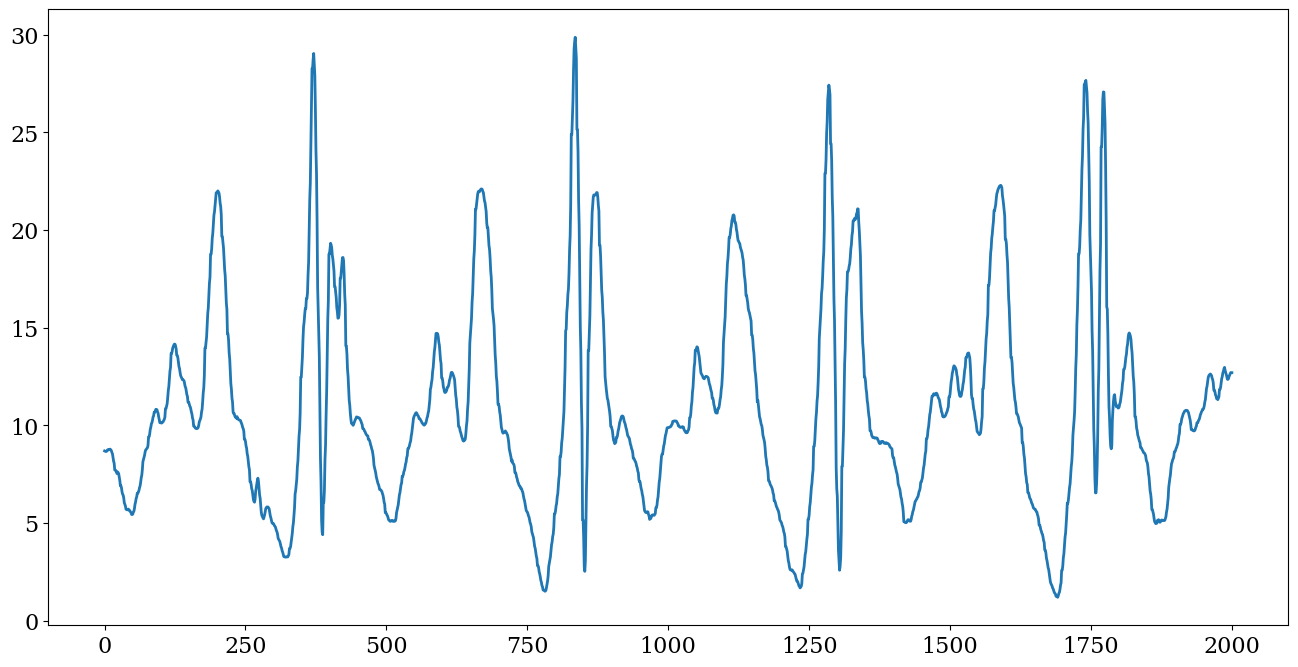

In [6]:
# исследуемый временной ряд - корень из суммы квадратов показаний акселерометра по осям
data['ts'] = data[['X_value', 'Y_value', 'Z_value']].pow(2).sum(axis = 1).pow(0.5)
data.loc[:2000,'ts'].plot()

In [7]:
X = HankelMatrix(data['ts'] , 500)
X.shape

(39502, 500)

In [8]:
from sklearn.decomposition import KernelPCA, PCA

Пример восстановленной фазовой траектории в пространстве размерности 3

временной ряд -> метод задержек -> PCA -> 3 главные компоненты, как оценка координат изначальной системы

In [9]:
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(X)

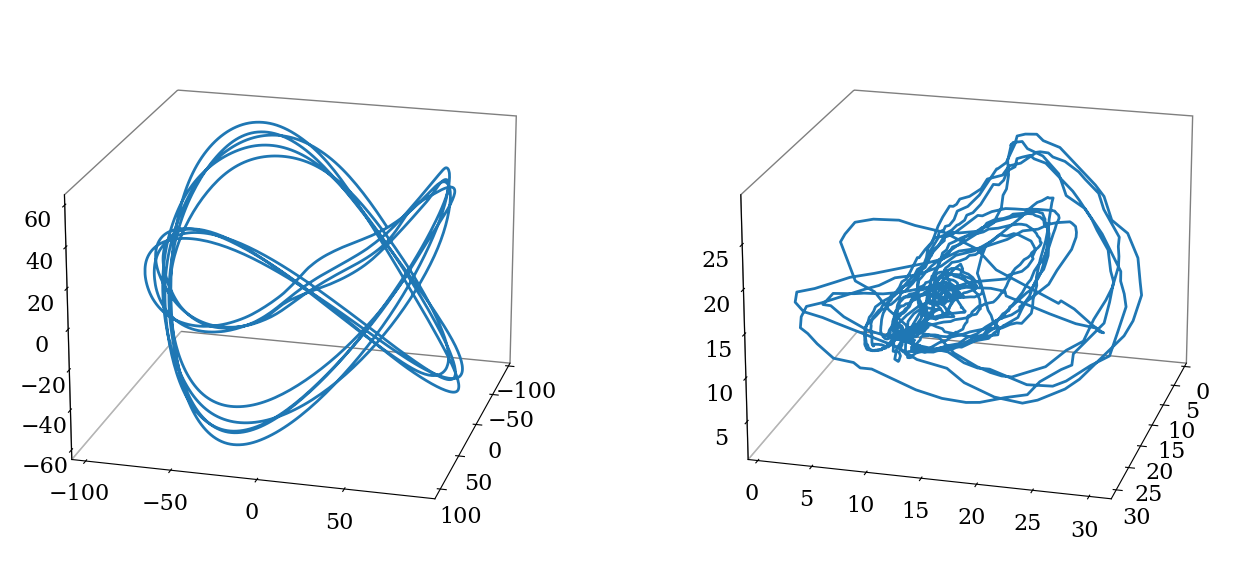

In [10]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1,2,1, projection='3d')
# метод  PCA
ax.plot(
    X_PCA[:2000,0],
    X_PCA[:2000,1],
    X_PCA[:2000,2]
)

ax.view_init(elev=20, azim=15)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax2 = fig.add_subplot(1,2,2, projection='3d')
# 3 случайные точки из предыстории
ax2.plot(
    X[:2000,0],
    X[:2000,20],
    X[:2000,30]
)

ax2.view_init(elev=20, azim=15)

ax2.grid(False)
ax2.xaxis.pane.set_edgecolor('black')
ax2.yaxis.pane.set_edgecolor('black')
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False


plt.show()

# Задание

Набор данных включает в себя данные временных рядов, генерируемые датчиками акселерометра и гироскопа.
https://github.com/mmalekzadeh/motion-sense/tree/master

1. Выбрать один из датасетов ходьбы ```wlk_*``` или бега ```jog_*``` для одного человека ```sub_*```
2. Проанализировать связь между показателями акселерометра и гироскопа
    - Графики автокорреляций
    - Тест Грэнджера на причинность ([пример](https://phdinds-aim.github.io/time_series_handbook/04_GrangerCausality/04_GrangerCausality.html))
    - CCM ([пример](https://phdinds-aim.github.io/time_series_handbook/06_ConvergentCrossMappingandSugiharaCausality/ccm_sugihara.html))
3. Посторить фазовую траекторию (пример выше), проанализировать формы полученных множеств (Если по CCM делается вывод о связи временных рядов, то их фазовые траектории будут похожи)    
    - По 3 случайным точкам из предыстории
    - Методом PCA
    - Другим методом снижения размерности (например, t-sne, kernel PCA, UMAP и тд)
4. Разложить временной ряд на компоненты
    - Методом ```from statsmodels.tsa.seasonal import seasonal_decompose```
    - Методом ```from scipy.fftpack import fft``` (как в семинаре)
    - Методом SSA ([пример](https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition/notebook)) (как в семинаре)
    - Обучить и проанализировать результаты двух ARIMA моделей на начальном и обработанном с помощью SSA (только для акселерометра)

<font color="green"><b>
Explanation:
</b></font>

---


В качестве человека я выбрал мужчину под 11 номером:
Weight (kg): 70
Height (cm): 178
Age (years): 24





In [11]:
# предварительно загруженный датасет
print(os.listdir('./'))

['.config', 'sub_11.csv', 'sample_data']


In [54]:
data = pd.read_csv('./sub_11.csv')
data = data[[
    'rotationRate.x',
    'rotationRate.y',
    'rotationRate.z',
    'userAcceleration.x',
    'userAcceleration.y',
    'userAcceleration.z'
]]

In [55]:
# подготовка временных рядов
data['rot'] = data[['rotationRate.x', 'rotationRate.y', 'rotationRate.z']].pow(2).sum(axis = 1).pow(0.5)
data['acc'] = data[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']].pow(2).sum(axis = 1).pow(0.5)

<Axes: >

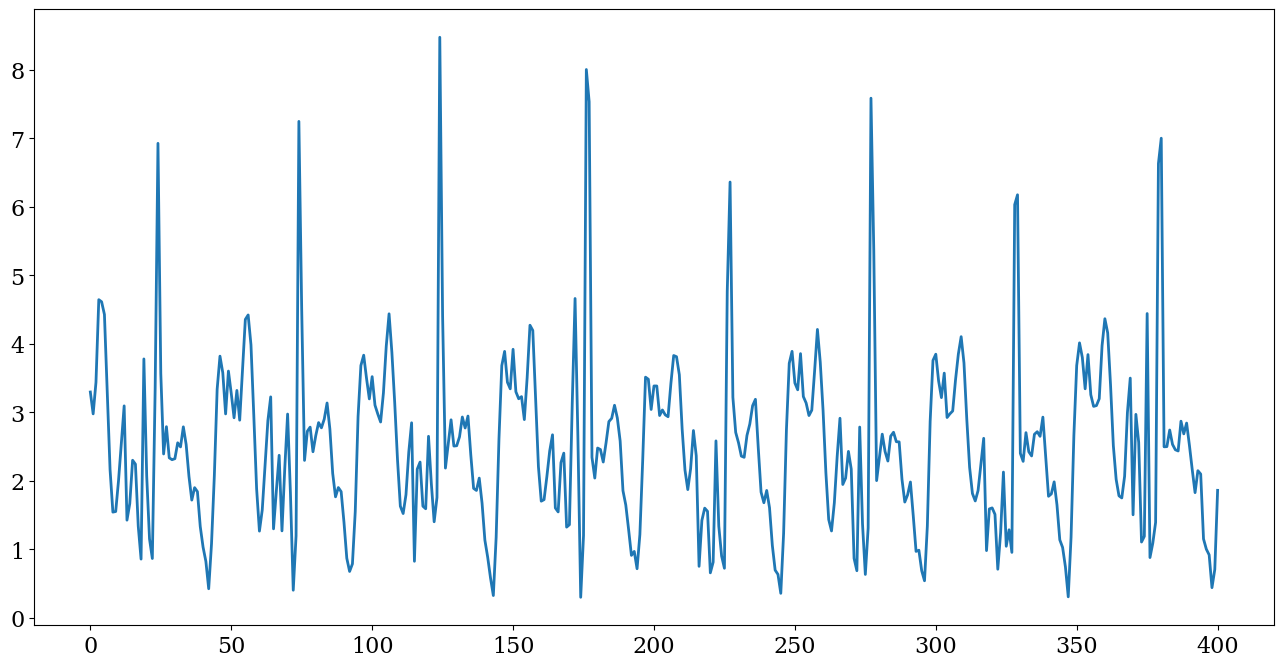

In [14]:
data.loc[:400,'rot'].plot()

<Axes: >

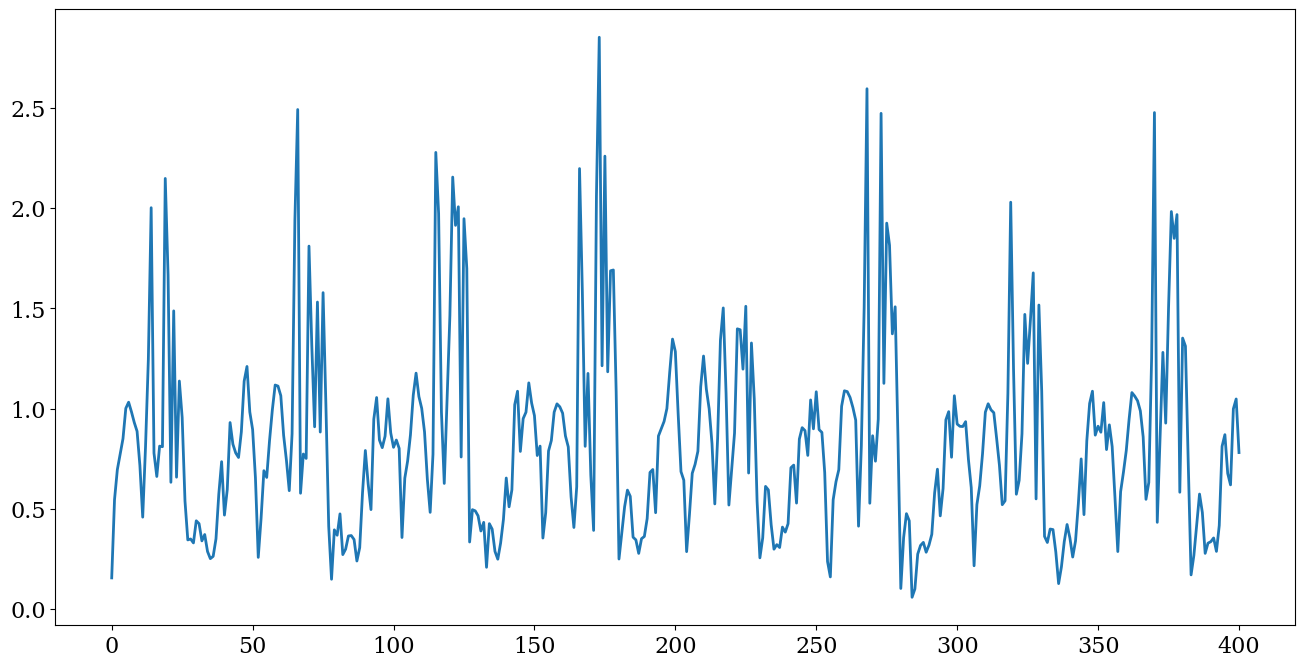

In [15]:
data.loc[:400,'acc'].plot()

# Графики автокорреляций

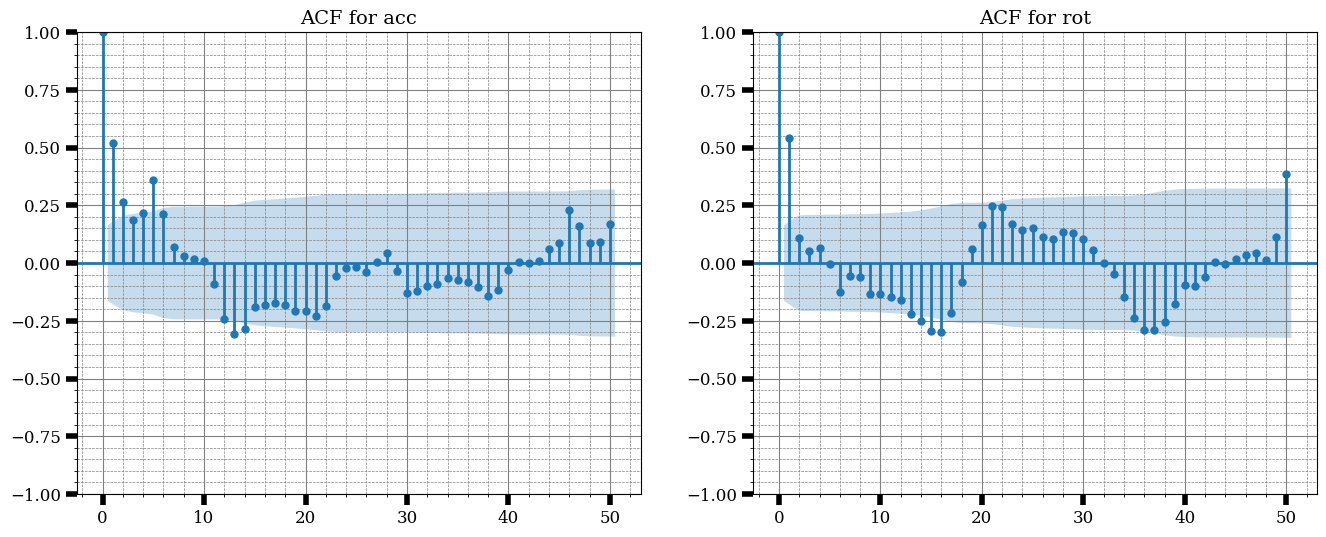

In [17]:
import statsmodels.graphics.tsaplots as stag
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

stag.plot_acf(data.acc[:100], lags=50, use_vlines=True, alpha=0.1, ax=axs[0])
axs[0].tick_params(axis='both', which='major', labelsize=12, length=8, width=4)
axs[0].grid(which='major', color='gray', linewidth=0.8)
axs[0].minorticks_on()
axs[0].grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
axs[0].set_title('ACF for acc', fontsize=14)

stag.plot_acf(data.rot[:100], lags=50, use_vlines=True, alpha=0.1, ax=axs[1])
axs[1].tick_params(axis='both', which='major', labelsize=12, length=8, width=4)
axs[1].grid(which='major', color='gray', linewidth=0.8)
axs[1].minorticks_on()
axs[1].grid(which='minor', color='gray', linestyle='--', linewidth=0.5)
axs[1].set_title('ACF for rot', fontsize=14)


# Отображение графика
plt.show()


#Тест Грэнджера на причинность


###Памятка

**AIC** - сокращение от "Akaike Information Criterion" (критерий информационной энтропии Акаике) - это мера относительной качества статистической модели для определения, насколько хорошо модель описывает данные, учитывая количество параметров модели.

**BIC** - сокращение от "Bayesian Information Criterion" (байесовский критерий информационной энтропии) - это другая мера относительной качества статистической модели, которая также учитывает количество параметров модели. BIC основан на байесовском подходе, который позволяет оценить вероятность того, что модель является истинной моделью, учитывая количество параметров и размер выборки.

**HQIC** - сокращение от "Hannan-Quinn Information Criterion" (критерий информационной энтропии Ханнана-Квина) - это еще одна мера относительной качества статистической модели, которая учитывает количество параметров модели. HQIC основан на методе максимального правдоподобия и является модификацией критерия Акаике (AIC). HQIC штрафует модели с большим количеством параметров сильнее, чем AIC, но не так сильно, как BIC.

**FPE** - сокращение от "Final Prediction Error" (ошибка финального прогноза) - это мера качества модели, которая используется для оценки точности прогнозов, сделанных на основе модели. FPE вычисляется как ошибка прогноза на последнем шаге (т.е. на последнем элементе выборки), используя модель, обученную на всех предыдущих элементах выборки.


In [18]:
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

In [19]:
train_df, test_df = splitter(data.loc[:, ['rot', 'acc']])

In [20]:
from statsmodels.tsa.vector_ar.var_model import VAR

AIC     53
BIC     32
HQIC    51
FPE     53
dtype: int64


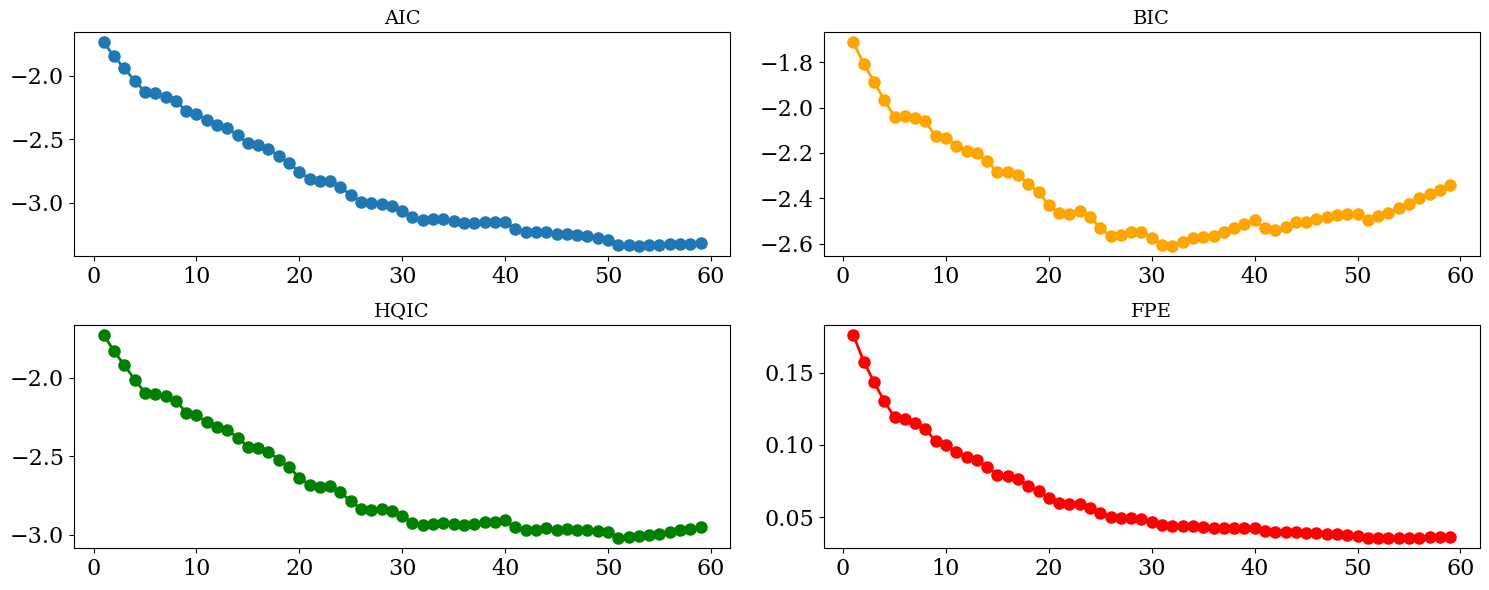

In [21]:
def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df)
    p = np.arange(1,60)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic,
                                    'BIC': bic,
                                    'HQIC': hqic,
                                    'FPE': fpe},
                                   index=p)
    fig, axs = plt.subplots(2, 2, figsize=(15, 6))
    axs = axs.flatten()
    lags_metrics_df['AIC'].plot(ax=axs[0], marker='o')
    axs[0].set_title('AIC', fontsize=14)
    lags_metrics_df['BIC'].plot(ax=axs[1], marker='o', color='orange')
    axs[1].set_title('BIC', fontsize=14)
    lags_metrics_df['HQIC'].plot(ax=axs[2], marker='o', color='green')
    axs[2].set_title('HQIC', fontsize=14)
    lags_metrics_df['FPE'].plot(ax=axs[3], marker='o', color='red')
    axs[3].set_title('FPE', fontsize=14)
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))


select_p(train_df)

<font color="green"><b>
Explanation:
</b></font>

---

 Мы видим, что BIC имеет самое низкое значение на уровне p = 33
в то время как HQIC в p = 53
. Хотя и AIC, и FPE имеют самое низкое значение при p = 55
, их графики также показывают экспоненциальное затухание. Таким образом, мы можем выбрать количество лагов равное 33 (также для эффективности вычислений).

Теперь мы согласуем модель VAR с выбранным порядком.

In [22]:
p = 33
model = VAR(train_df)
var_model = model.fit(p)

In [23]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_causation_matrix(data, variables, p, test = 'ssr_chi2test', verbose=False):
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table
    are the P-Values. P-Values lesser than the significance level (0.05), implies
    the Null Hypothesis that the coefficients of the corresponding past values is
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [24]:
granger_causation_matrix(train_df, train_df.columns, p)

,rot_x,acc_x
rot_y,1.0,0.0
acc_y,0.0,1.0


<font color="green"><b>
Explanation:
</b></font>

---

*Согласно примеру:* если данное значение p < уровня значимости (0,05), то соответствующая серия X (столбец) вызывает Y (строку).

В данном случае, результаты теста показывают, что ряд rot_x причинно влияет на ряд rot_y, но не влияет на ряд acc_x. Аналогично, ряд acc_x не влияет на ряд rot_y, но влияет на ряд acc_y.

Значения 1.0 на диагонали матрицы означают, что каждый ряд является причиной самого себя (автокорреляция), что является логичным результатом. Значения 0.0 означают, что никакой причинно-следственной связи между этими рядами не обнаружено.

#CCM

In [25]:
from scipy.spatial import distance
from scipy.stats import pearsonr

# Computing "Causality" (Correlation between True and Predictions)
class ccm:
    def __init__(self, X, Y, tau=1, E=2, L=500):
        '''
        X: timeseries for variable X that could cause Y
        Y: timeseries for variable Y that could be caused by X
        tau: time lag
        E: shadow manifold embedding dimension
        L: time period/duration to consider (longer = more data)
        We're checking for X -> Y
        '''
        self.X = X
        self.Y = Y
        self.tau = tau
        self.E = E
        self.L = L
        self.My = self.shadow_manifold(Y) # shadow manifold for Y (we want to know if info from X is in Y)
        self.t_steps, self.dists = self.get_distances(self.My) # for distances between points in manifold

    def shadow_manifold(self, X):
        """
        Given
            X: some time series vector
            tau: lag step
            E: shadow manifold embedding dimension
            L: max time step to consider - 1 (starts from 0)
        Returns
            {t:[t, t-tau, t-2*tau ... t-(E-1)*tau]} = Shadow attractor manifold, dictionary of vectors
        """
        X = X[:self.L] # make sure we cut at L
        M = {t:[] for t in range((self.E-1) * self.tau, self.L)} # shadow manifold
        for t in range((self.E-1) * self.tau, self.L):
            x_lag = [] # lagged values
            for t2 in range(0, self.E-1 + 1): # get lags, we add 1 to E-1 because we want to include E
                x_lag.append(X[t-t2*self.tau])
            M[t] = x_lag
        return M

    def get_distances(self, Mx):
        """
        Args
            Mx: The shadow manifold from X
        Returns
            t_steps: timesteps
            dists: n x n matrix showing distances of each vector at t_step (rows) from other vectors (columns)
        """

        # we extract the time indices and vectors from the manifold Mx
        # we just want to be safe and convert the dictionary to a tuple (time, vector)
        # to preserve the time inds when we separate them
        t_vec = [(k, v) for k,v in Mx.items()]
        t_steps = np.array([i[0] for i in t_vec])
        vecs = np.array([i[1] for i in t_vec])
        dists = distance.cdist(vecs, vecs)
        return t_steps, dists

    def get_nearest_distances(self, t, t_steps, dists):
        """
        Args:
            t: timestep of vector whose nearest neighbors we want to compute
            t_teps: time steps of all vectors in Mx, output of get_distances()
            dists: distance matrix showing distance of each vector (row) from other vectors (columns). output of get_distances()
            E: embedding dimension of shadow manifold Mx
        Returns:
            nearest_timesteps: array of timesteps of E+1 vectors that are nearest to vector at time t
            nearest_distances: array of distances corresponding to vectors closest to vector at time t
        """
        t_ind = np.where(t_steps == t) # get the index of time t
        dist_t = dists[t_ind].squeeze() # distances from vector at time t (this is one row)

        # get top closest vectors
        nearest_inds = np.argsort(dist_t)[1:self.E+1 + 1] # get indices sorted, we exclude 0 which is distance from itself
        nearest_timesteps = t_steps[nearest_inds] # index column-wise, t_steps are same column and row-wise
        nearest_distances = dist_t[nearest_inds]

        return nearest_timesteps, nearest_distances

    def predict(self, t):
        """
        Args
            t: timestep at Mx to predict Y at same time step
        Returns
            Y_true: the true value of Y at time t
            Y_hat: the predicted value of Y at time t using Mx
        """
        eps = 0.000001 # epsilon minimum distance possible
        t_ind = np.where(self.t_steps == t) # get the index of time t
        dist_t = self.dists[t_ind].squeeze() # distances from vector at time t (this is one row)
        nearest_timesteps, nearest_distances = self.get_nearest_distances(t, self.t_steps, self.dists)

        # get weights
        u = np.exp(-nearest_distances/np.max([eps, nearest_distances[0]])) # we divide by the closest distance to scale
        w = u / np.sum(u)

        # get prediction of X
        X_true = self.X[t] # get corresponding true X
        X_cor = np.array(self.X)[nearest_timesteps] # get corresponding Y to cluster in Mx
        X_hat = (w * X_cor).sum() # get X_hat

        return X_true, X_hat

    def causality(self):
        '''
        Args:
            None
        Returns:
            correl: how much self.X causes self.Y. correlation between predicted Y and true Y
        '''

        # run over all timesteps in M
        # X causes Y, we can predict X using My
        # X puts some info into Y that we can use to reverse engineer X from Y
        X_true_list = []
        X_hat_list = []

        for t in list(self.My.keys()): # for each time step in My
            X_true, X_hat = self.predict(t) # predict X from My
            X_true_list.append(X_true)
            X_hat_list.append(X_hat)

        x, y = X_true_list, X_hat_list
        r, p = pearsonr(x, y)

        return r, p


    def visualize_cross_mapping(self):
        """
        Visualize the shadow manifolds and some cross mappings
        """
        # we want to check cross mapping from Mx to My and My to Mx

        f, axs = plt.subplots(2, 1, figsize=(12, 12))

        for i, ax in zip((0, 1), axs): # i will be used in switching Mx and My in Cross Mapping visualization
            #===============================================
            # Shadow Manifolds Visualization

            X_lag, Y_lag = [], []
            for t in range(1, len(self.X)):
                X_lag.append(self.X[t-self.tau])
                Y_lag.append(self.Y[t-self.tau])
            X_t, Y_t = self.X[1:], self.Y[1:] # remove first value

            ax.scatter(X_t, X_lag, s=5, label='$M_x$')
            ax.scatter(Y_t, Y_lag, s=5, label='$M_y$', c='y')

            #===============================================
            # Cross Mapping Visualization

            A, B = [(self.Y, self.X), (self.X, self.Y)][i]
            cm_direction = ['Mx to My', 'My to Mx'][i]

            Ma = self.shadow_manifold(A)
            Mb = self.shadow_manifold(B)

            t_steps_A, dists_A = self.get_distances(Ma) # for distances between points in manifold
            t_steps_B, dists_B = self.get_distances(Mb) # for distances between points in manifold

            # Plot cross mapping for different time steps
            timesteps = list(Ma.keys())
            for t in np.random.choice(timesteps, size=3, replace=False):
                Ma_t = Ma[t]
                near_t_A, near_d_A = self.get_nearest_distances(t, t_steps_A, dists_A)

                for i in range(self.E+1):
                    # points on Ma
                    A_t = Ma[near_t_A[i]][0]
                    A_lag = Ma[near_t_A[i]][1]
                    ax.scatter(A_t, A_lag, c='b', marker='s')

                    # corresponding points on Mb
                    B_t = Mb[near_t_A[i]][0]
                    B_lag = Mb[near_t_A[i]][1]
                    ax.scatter(B_t, B_lag, c='r', marker='*', s=50)

                    # connections
                    ax.plot([A_t, B_t], [A_lag, B_lag], c='r', linestyle=':')

            ax.set_title(f'{cm_direction} cross mapping. time lag, tau = {self.tau}, E = 5')
            ax.legend(prop={'size': 14})

            ax.set_xlabel('$X_t$, $Y_t$', size=15)
            ax.set_ylabel('$X_{t-1}$, $Y_{t-1}$', size=15)
        plt.show()


    def plot_ccm_correls(self):
        """
        Args
            X: X time series
            Y: Y time series
            tau: time lag
            E: shadow manifold embedding dimension
            L: time duration
        Returns
            None. Just correlation plots
        """
        M = self.shadow_manifold(self.Y) # shadow manifold
        t_steps, dists = self.get_distances(M) # for distances

        ccm_XY = ccm(self.X, self.Y, self.tau, self.E, self.L) # define new ccm object # Testing for X -> Y
        ccm_YX = ccm(self.Y, self.X, self.tau, self.E, self.L) # define new ccm object # Testing for Y -> X

        X_My_true, X_My_pred = [], [] # note pred X | My is equivalent to figuring out if X -> Y
        Y_Mx_true, Y_Mx_pred = [], [] # note pred Y | Mx is equivalent to figuring out if Y -> X

        for t in range(self.tau, self.L):
            true, pred = ccm_XY.predict(t)
            X_My_true.append(true)
            X_My_pred.append(pred)

            true, pred = ccm_YX.predict(t)
            Y_Mx_true.append(true)
            Y_Mx_pred.append(pred)

        # # plot
        figs, axs = plt.subplots(1, 2, figsize=(12, 5))

        # predicting X from My
        r, p = np.round(pearsonr(X_My_true, X_My_pred), 4)

        axs[0].scatter(X_My_true, X_My_pred, s=10)
        axs[0].set_xlabel('$X(t)$ (observed)', size=12)
        axs[0].set_ylabel('$\hat{X}(t)|M_y$ (estimated)', size=12)
        axs[0].set_title(f'tau={self.tau}, E={self.E}, L={self.L}, Correlation coeff = {r}')

        # predicting Y from Mx
        r, p = np.round(pearsonr(Y_Mx_true, Y_Mx_pred), 4)

        axs[1].scatter(Y_Mx_true, Y_Mx_pred, s=10)
        axs[1].set_xlabel('$Y(t)$ (observed)', size=12)
        axs[1].set_ylabel('$\hat{Y}(t)|M_x$ (estimated)', size=12)
        axs[1].set_title(f'tau={self.tau}, E={self.E}, L={self.L}, Correlation coeff = {r}')
        plt.show()

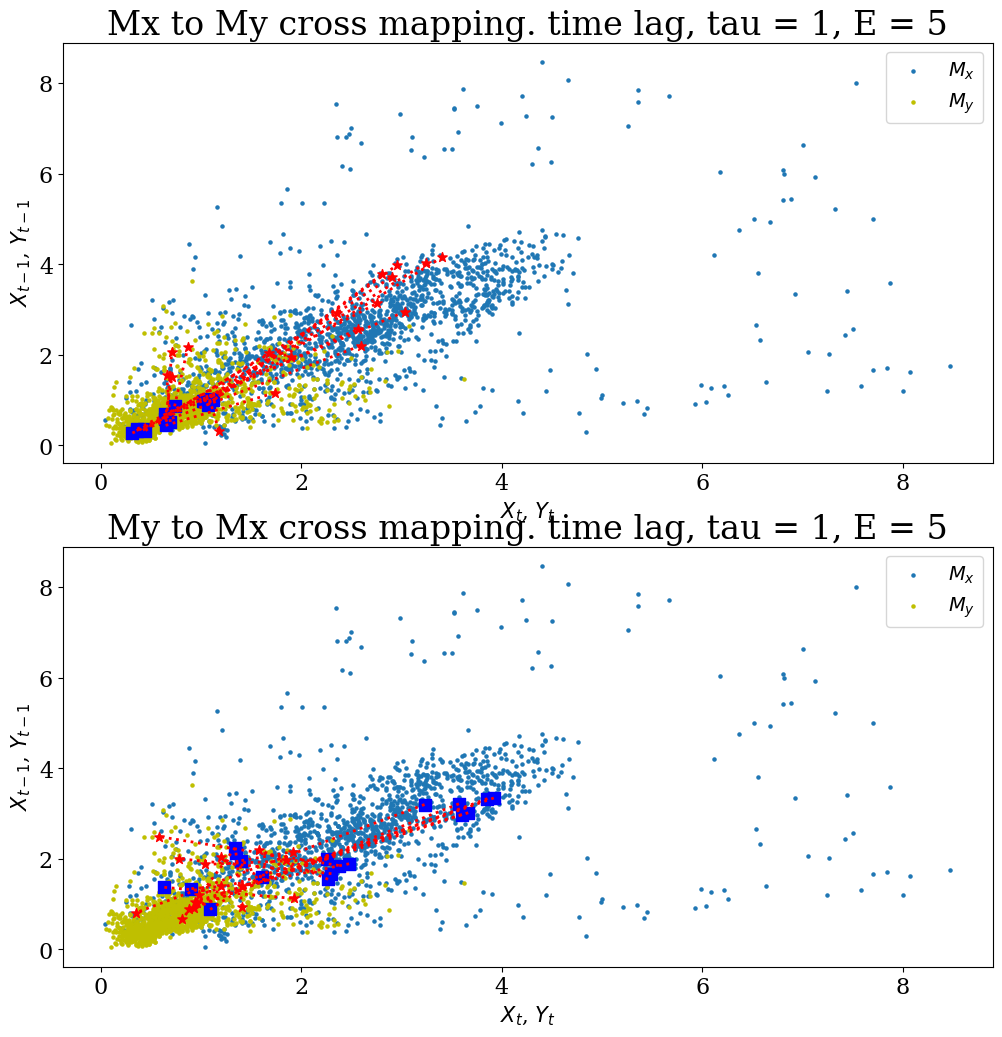

In [27]:
ccm1 = ccm(data.rot, data.acc, E=5)
ccm1.visualize_cross_mapping()

###Памятка

В контексте графика CCM (Cross-Mapping) для предсказания причинно-следственной связи, теневые многообразия могут использоваться для создания пространства, в котором можно производить вычисления и анализировать данные.

Теневые многообразия создаются путем задержки исходных временных рядов на определенное количество временных шагов. Это позволяет создать новое пространство, в котором каждая точка представляет собой набор значений из исходных временных рядов в разные моменты времени.

Таким образом, теневые многообразия используются для создания нового пространства, в котором можно производить анализ данных и определять причинно-следственные связи между различными переменными.

<font color="green"><b>
Explanation:
</b></font>

---
В теневых многообразиях, которые мы видим выше, мы демонстрируем отображение точек одного многообразия (обозначено синей рамкой) в соответствующие точки другого многообразия (обозначено красной звездой).

Чем сильнее связь между переменными, тем более выраженным будет перекрестное отображение. Например, в случае перекрестного отображения Mx от My (верхняя диаграмма), это может указывать на то, что переменная X оказывает влияние на переменную Y.


#Посторение фазовых траекторий

###Памятка

t-SNE (t-distributed stochastic neighbor embedding) - это метод многомерного шкалирования, используемый для визуализации данных высокой размерности в двух или трех измерениях. Он используется для поиска структуры в данных и уменьшения размерности данных.

t-SNE основан на вероятностной модели, которая пытается сохранить сходство между парами точек в исходном пространстве при отображении их на более низкую размерность. Он использует распределение t-Student для оценки вероятности сходства между точками в исходном пространстве и в пространстве назначения.

##Rot

In [28]:
from sklearn.manifold import TSNE

In [29]:
X = HankelMatrix(data.rot , 500)

In [30]:
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(X)
t_sne = TSNE(n_components=3)
X_TSNE = t_sne.fit_transform(X)

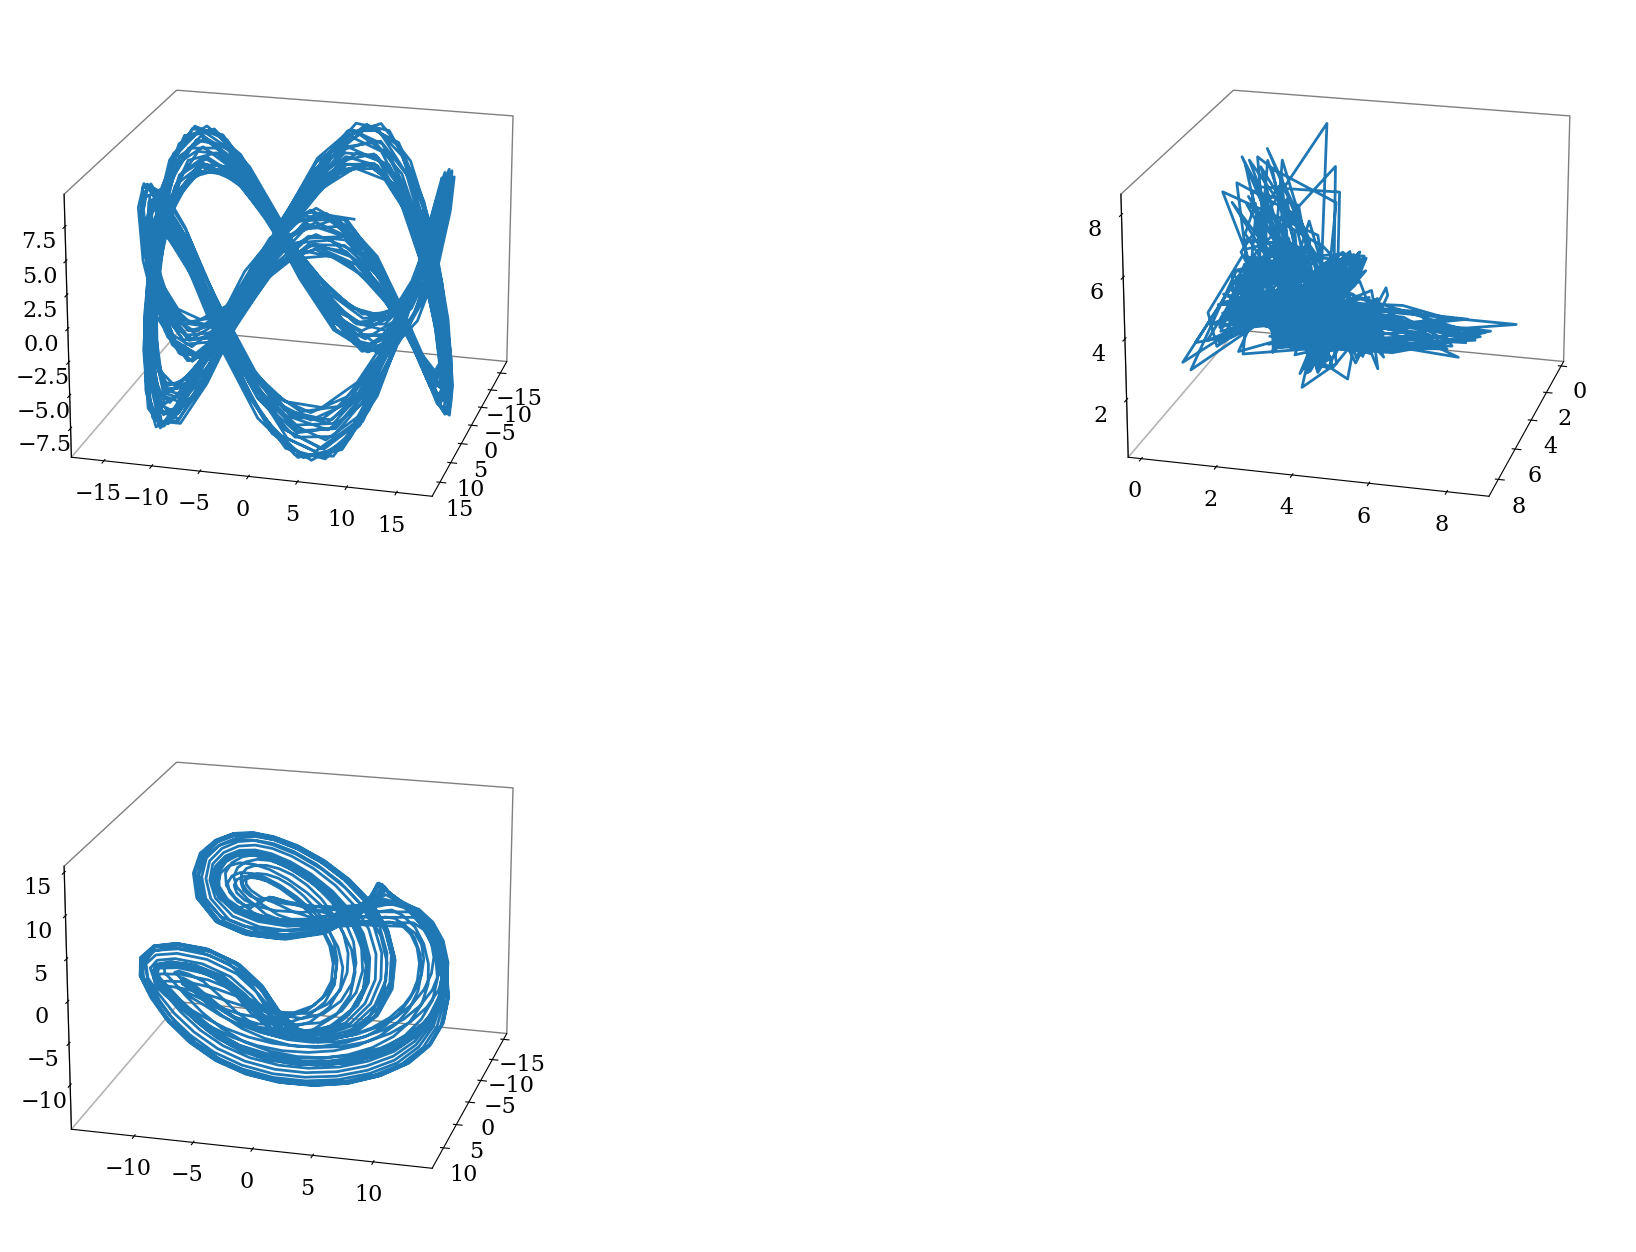

In [31]:
fig = plt.figure(figsize=(25, 16))
ax = fig.add_subplot(2,2,1, projection='3d')
# метод  PCA
ax.plot(
    X_PCA[:2000,0],
    X_PCA[:2000,1],
    X_PCA[:2000,2]
)

ax.view_init(elev=20, azim=15)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax2 = fig.add_subplot(2,2,2, projection='3d')
# 3 случайные точки из предыстории
ax2.plot(
    X[:2000,0],
    X[:2000,20],
    X[:2000,30]
)

ax2.view_init(elev=20, azim=15)

ax2.grid(False)
ax2.xaxis.pane.set_edgecolor('black')
ax2.yaxis.pane.set_edgecolor('black')
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False


# T-SNE
ax3 = fig.add_subplot(2,2,3, projection='3d')
ax3.plot(
    X_TSNE[:2000,0],
    X_TSNE[:2000,1],
    X_TSNE[:2000,2]
)

ax3.view_init(elev=20, azim=15)

ax3.grid(False)
ax3.xaxis.pane.set_edgecolor('black')
ax3.yaxis.pane.set_edgecolor('black')
ax3.xaxis.pane.fill = False
ax3.yaxis.pane.fill = False
ax3.zaxis.pane.fill = False



plt.show()

##Acc

In [32]:
X = HankelMatrix(data.acc , 500)

In [33]:
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(X)
t_sne = TSNE(n_components=3)
X_TSNE = t_sne.fit_transform(X)

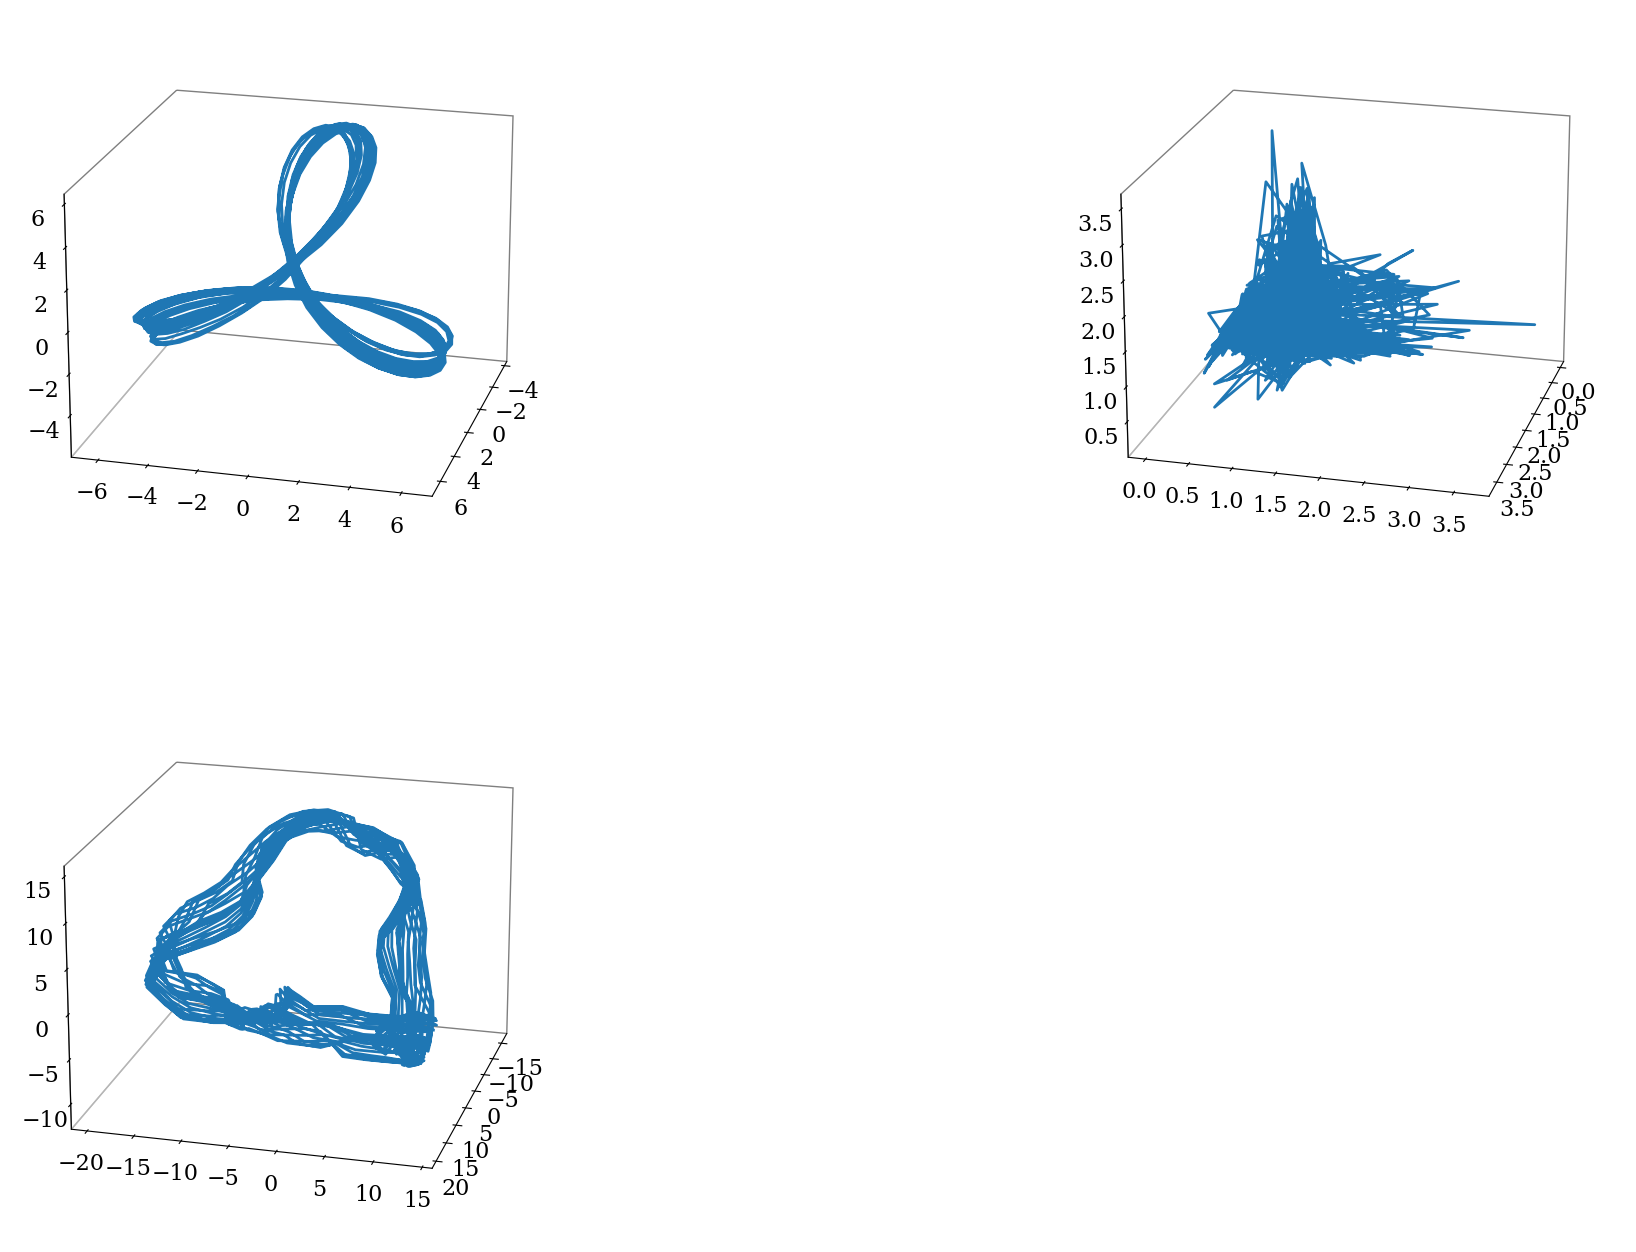

In [34]:
fig = plt.figure(figsize=(25, 16))
ax = fig.add_subplot(2,2,1, projection='3d')
# метод  PCA
ax.plot(
    X_PCA[:2000,0],
    X_PCA[:2000,1],
    X_PCA[:2000,2]
)

ax.view_init(elev=20, azim=15)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax2 = fig.add_subplot(2,2,2, projection='3d')
# 3 случайные точки из предыстории
ax2.plot(
    X[:2000,0],
    X[:2000,20],
    X[:2000,30]
)

ax2.view_init(elev=20, azim=15)

ax2.grid(False)
ax2.xaxis.pane.set_edgecolor('black')
ax2.yaxis.pane.set_edgecolor('black')
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False


# T-SNE
ax3 = fig.add_subplot(2,2,3, projection='3d')
ax3.plot(
    X_TSNE[:2000,0],
    X_TSNE[:2000,1],
    X_TSNE[:2000,2]
)

ax3.view_init(elev=20, azim=15)

ax3.grid(False)
ax3.xaxis.pane.set_edgecolor('black')
ax3.yaxis.pane.set_edgecolor('black')
ax3.xaxis.pane.fill = False
ax3.yaxis.pane.fill = False
ax3.zaxis.pane.fill = False



plt.show()

<font color="green"><b>
Explanation:
</b></font>

---

Фазовая траектории гироскопа и акселерометра имеют **квазипериодическая форму**, но повторяющуюся структуру, это может указывать на периодическое поведение системы. Что логично, учитывая что мы наблюдаем за гироскопом и акселерометра

#Разложение временного ряда на компоненты

##Метод seasonal_decompose

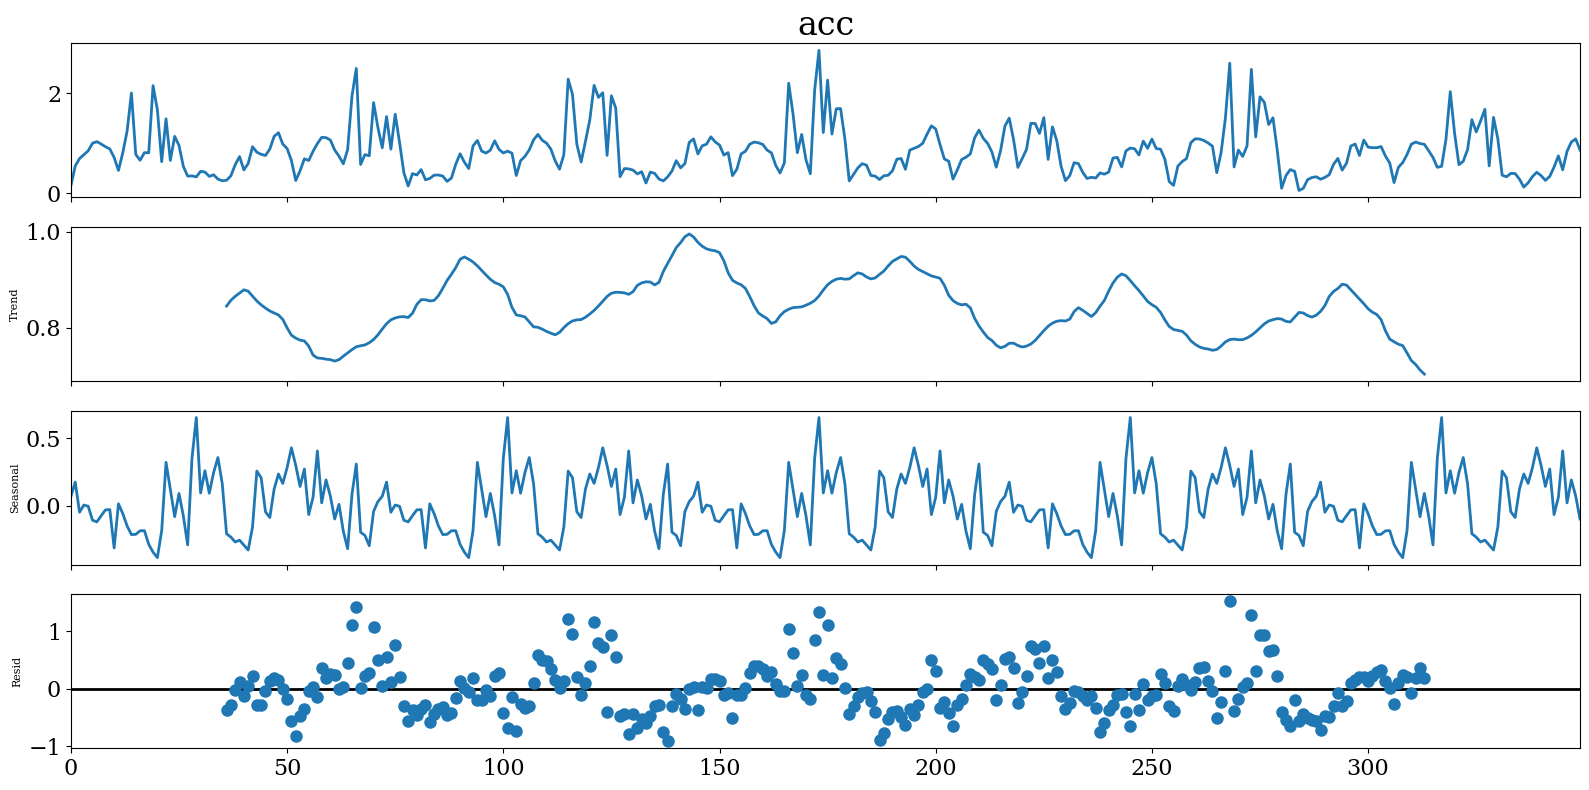

In [36]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 72
res = seasonal_decompose(data.acc[:350],
                         period=decompfreq,
                         model='additive')
resplot = res.plot()
resplot.savefig('Seasonal_Decompose.png')

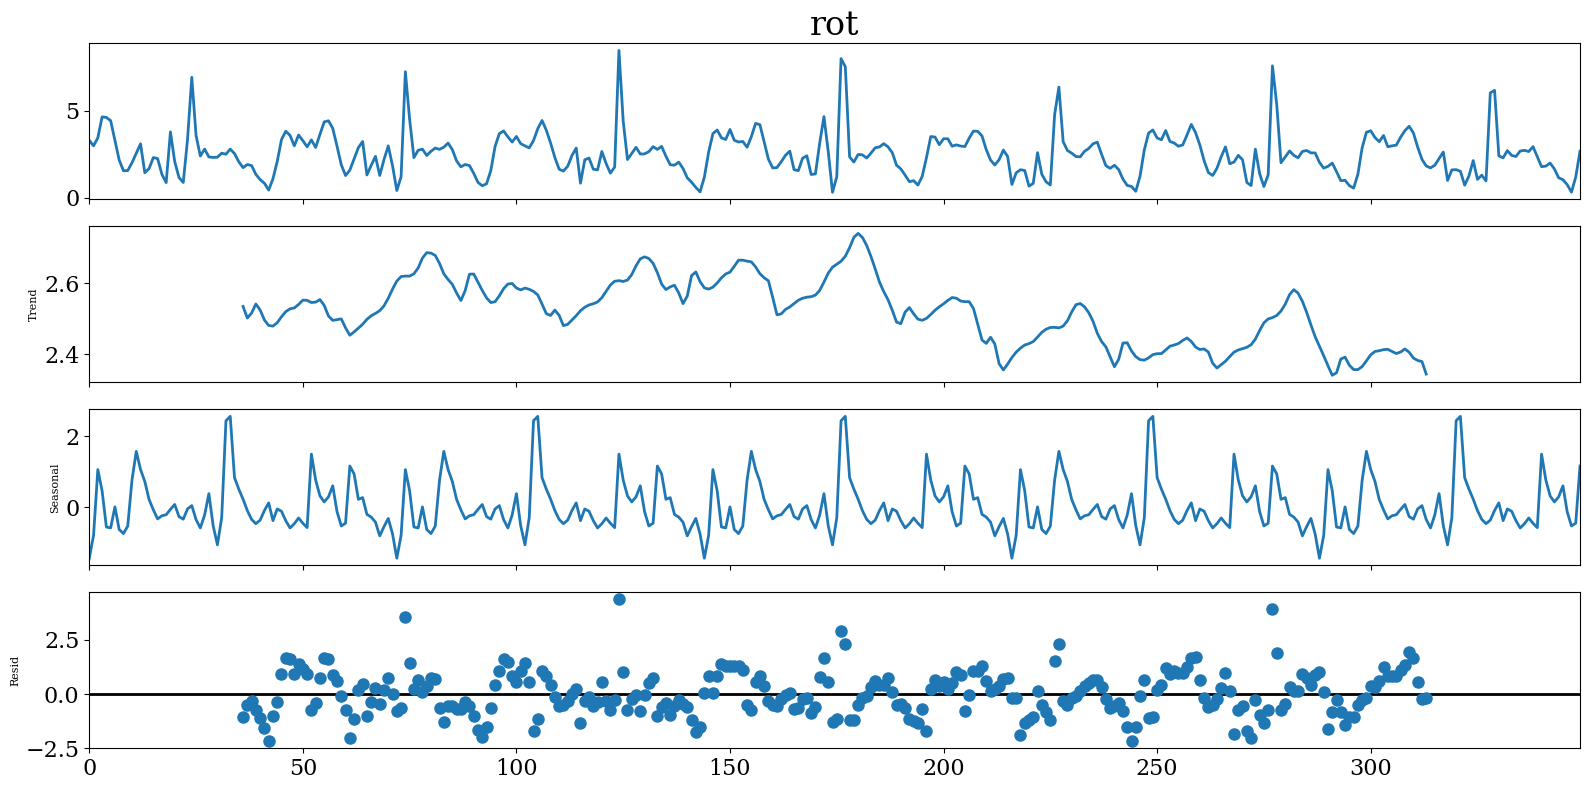

In [37]:
res = seasonal_decompose(data.rot[:350],
                         period=decompfreq,
                         model='additive')
resplot = res.plot()
resplot.savefig('Seasonal_Decompose.png')

##Метод FFT

####Acc

In [57]:
ts_acc_fft = data.acc.values[:350]
ts_acc_fft = ts_acc_fft-ts_acc_fft.mean()

num_to_print = 500

Fs = 1

N = len(ts_acc_fft)

__FS = np.linspace(0.0, 1.0/2.0 * Fs, N//2)

__Abs = 2.0/N * np.abs(fft(ts_acc_fft)[0:N//2]) #нормирование

# plotting the spectrum
fig = go.Figure()
fig.add_scatter(
    x = __FS[0:num_to_print],
    y = __Abs[0:num_to_print],
    mode='lines',
    name='Magnitude'
)

temp_fft = fft(ts_acc_fft)[0:N//2]

__Ph = np.arctan2(np.imag(temp_fft),np.real(temp_fft))

fig.add_scatter(
    x = __FS[0:num_to_print],
    y = __Ph[0:num_to_print],
    mode='markers',
    name='Phase'
)

fig.add_trace(
    go.Bar(
        x= __FS[0:num_to_print],
        y= __Ph[0:num_to_print],
        name='Phase'
    )
)

fig['layout']['yaxis1'].update(title='Magnitude')
fig['layout']['xaxis1'].update(title='Frec [1/day]')
fig.show()

In [58]:
pd_Abs = pd.DataFrame(__Abs).sort_values(0, ascending=False)

n_fig = 350
fig = go.Figure()

fig.add_scatter(
    x = np.arange(n_fig),
    y = ts_acc_fft[:n_fig],
    mode = 'lines',
    name = 'Real')

t = np.arange(n_fig)

for i, ind in enumerate(pd_Abs.index.values[:10]):
  x = __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])

  fig.add_scatter(
      x = t[:n_fig],
      y = x,
      mode='lines',
      name=f'{i} frec'
  )

for i, ind in enumerate(pd_Abs.index.values[:5]):
  if i == 0:
    x = __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])
  else:
    x+= __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])

fig.add_scatter(
    x = t[:n_fig],
    y = x,
    mode='lines',
    name='0-9 frec'
)

fig.show()

####Rot

In [44]:
ts_rot_fft = data.rot.values[:350]
ts_rot_fft = ts_rot_fft-ts_rot_fft.mean()

num_to_print = 500

Fs = 1

N = len(ts_rot_fft)

__FS = np.linspace(0.0, 1.0/2.0 * Fs, N//2)

__Abs = 2.0/N * np.abs(fft(ts_rot_fft)[0:N//2]) #нормирование

# plotting the spectrum
fig = go.Figure()
fig.add_scatter(
    x = __FS[0:num_to_print],
    y = __Abs[0:num_to_print],
    mode='lines',
    name='Magnitude'
)

temp_fft = fft(ts_rot_fft)[0:N//2]

__Ph = np.arctan2(np.imag(temp_fft),np.real(temp_fft))

fig.add_scatter(
    x = __FS[0:num_to_print],
    y = __Ph[0:num_to_print],
    mode='markers',
    name='Phase'
)

fig.add_trace(
    go.Bar(
        x= __FS[0:num_to_print],
        y= __Ph[0:num_to_print],
        name='Phase'
    )
)

fig['layout']['yaxis1'].update(title='Magnitude')
fig['layout']['xaxis1'].update(title='Frec [1/day]')
fig.show()

In [45]:
pd_Abs = pd.DataFrame(__Abs).sort_values(0, ascending=False)

n_fig = 350
fig = go.Figure()

fig.add_scatter(
    x = np.arange(n_fig),
    y = ts_rot_fft[:n_fig],
    mode = 'lines',
    name = 'Real')

t = np.arange(n_fig)

for i, ind in enumerate(pd_Abs.index.values[:10]):
  x = __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])

  fig.add_scatter(
      x = t[:n_fig],
      y = x,
      mode='lines',
      name=f'{i} frec'
  )

for i, ind in enumerate(pd_Abs.index.values[:5]):
  if i == 0:
    x = __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])
  else:
    x+= __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])

fig.add_scatter(
    x = t[:n_fig],
    y = x,
    mode='lines',
    name='0-9 frec'
)

fig.show()

##Метод SSA

In [39]:
class SSA(object):

    __supported_types = (pd.Series, np.ndarray, list)

    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.

        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list.
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.

        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """

        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")

        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")

        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1

        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T

        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)

        self.TS_comps = np.zeros((self.N, self.d))

        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]

            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."

            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."

        # Calculate the w-correlation matrix.
        self.calc_wcorr()

    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d

        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)


    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.

        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]

        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)

    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """

        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])

        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)

        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5

        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]

    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d

        if self.Wcorr is None:
            self.calc_wcorr()

        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)

        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max

        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

###Acc

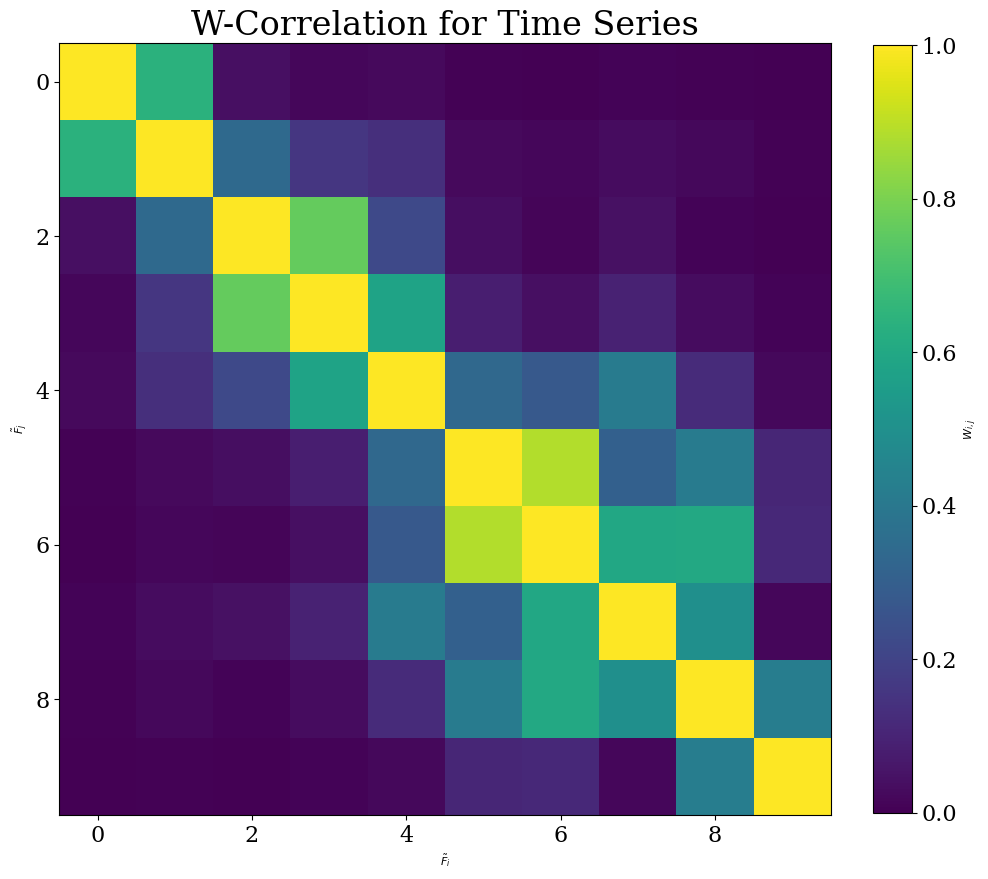

In [35]:
ts = data.acc.values[:350]
ts = ts-ts.mean()
ts_ssa_acc = SSA(ts, 10)

plt.figure(figsize=(11, 11))
ts_ssa_acc.plot_wcorr(max=10)
plt.title("W-Correlation for Time Series");

In [36]:
n_fig = 350
fig = go.Figure()

fig.add_scatter(
    x = np.arange(n_fig),
    y = ts[:n_fig],
    mode='lines',
    name='Real')

for i in range(5):
  fig.add_scatter(
      x = np.arange(n_fig),
      y = ts_ssa_acc.reconstruct(i)[:n_fig],
      mode='lines',
      name=f'{i} component SSA'
  )

fig.add_scatter(
      x = np.arange(n_fig),
      y = ts_ssa_acc.reconstruct(slice(0,5))[:n_fig],
      mode='lines',
      name=f'0-5 components SSA'
  )

fig.show()

###Сравнение

Для корректного сравнения нужно сначала выполнить код в ячейке FFT ACC

In [41]:
n_fig = 350
fig = go.Figure()

fig.add_scatter(
    x = np.arange(n_fig),
    y = ts[:n_fig],
    mode='lines',
    name='Real')

fig.add_scatter(
    x = np.arange(n_fig),
    y = ts_ssa_acc.reconstruct(slice(0,5))[:n_fig],
    mode='lines',
    name='SSA'
)


for i, ind in enumerate(pd_Abs.index.values[:5]):
  if i == 0:
    x = __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])
  else:
    x+= __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])

fig.add_scatter(
    x = t[:n_fig],
    y = x,
    mode='lines',
    name='FFT'
)

fig.show()

###Rot

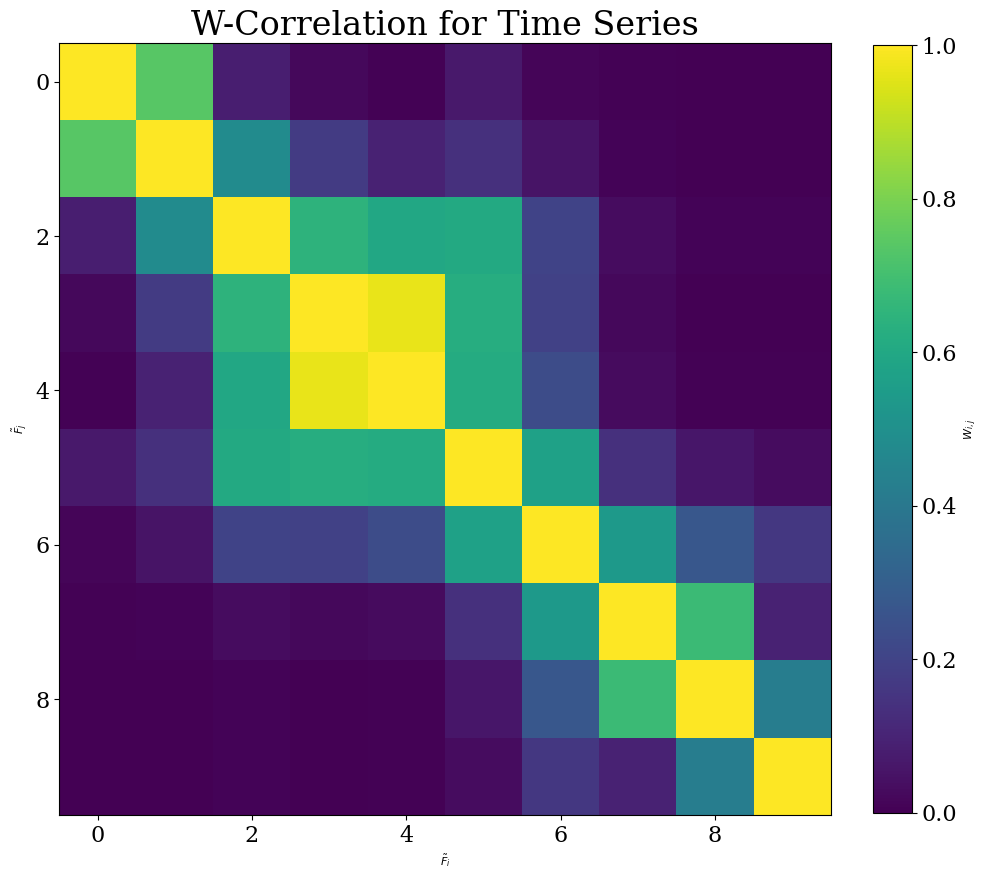

In [42]:
ts = ts = data.rot.values[:350]
ts = ts-ts.mean()
ts_ssa = SSA(ts, 10)

plt.figure(figsize=(11, 11))
ts_ssa.plot_wcorr(max=10)
plt.title("W-Correlation for Time Series");

In [43]:
n_fig = 350
fig = go.Figure()

fig.add_scatter(
    x = np.arange(n_fig),
    y = ts[:n_fig],
    mode='lines',
    name='Real')

for i in range(5):
  fig.add_scatter(
      x = np.arange(n_fig),
      y = ts_ssa.reconstruct(i)[:n_fig],
      mode='lines',
      name=f'{i} component SSA'
  )

fig.add_scatter(
      x = np.arange(n_fig),
      y = ts_ssa.reconstruct(slice(0,5))[:n_fig],
      mode='lines',
      name=f'0-5 components SSA'
  )

fig.show()

###Сравнение

Для корректного сравнения нужно сначала выполнить код в ячейке FFT ROT

In [46]:
n_fig = 100
fig = go.Figure()

fig.add_scatter(
    x = np.arange(n_fig),
    y = ts[:n_fig],
    mode='lines',
    name='Real')

fig.add_scatter(
    x = np.arange(n_fig),
    y = ts_ssa.reconstruct(slice(0,5))[:n_fig],
    mode='lines',
    name='SSA'
)


for i, ind in enumerate(pd_Abs.index.values[:5]):
  if i == 0:
    x = __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])
  else:
    x+= __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])

fig.add_scatter(
    x = t[:n_fig],
    y = x,
    mode='lines',
    name='FFT'
)

fig.show()

##Обучение Arima моделей

Для корректного обучения нужно сначала выполнить код в ячейках FFT ACC


###FFT

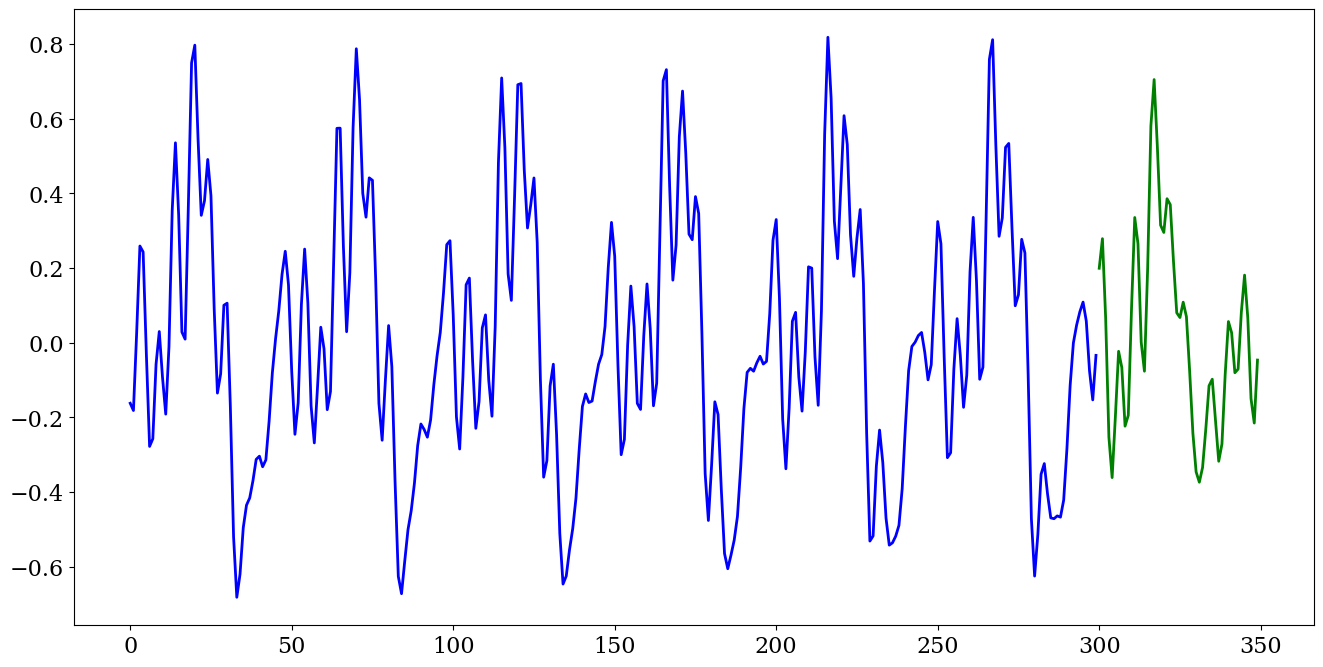

In [65]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Load/split your data
for i, ind in enumerate(pd_Abs.index.values[:5]):
  if i == 0:
    y = __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])
  else:
    y+= __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])

train, test = train_test_split(y, train_size=300)

model = pm.auto_arima(train, seasonal=True, m=12)
forecasts_fft = model.predict(test.shape[0])

x = np.arange(y.shape[0])
plt.plot(x[:300], train, c='blue')
plt.plot(x[300:], forecasts_fft, c='green')
plt.show()

###SSA

До того как мы начнем обучать, сделаем ssa для более меньшего датасета, чтобы мы могли быстрее обучаться


In [66]:
ts = data.acc.values[:350]
ts = ts-ts.mean()
ts_ssa_acc = SSA(ts, 10) #убрать эту и ячейку выше

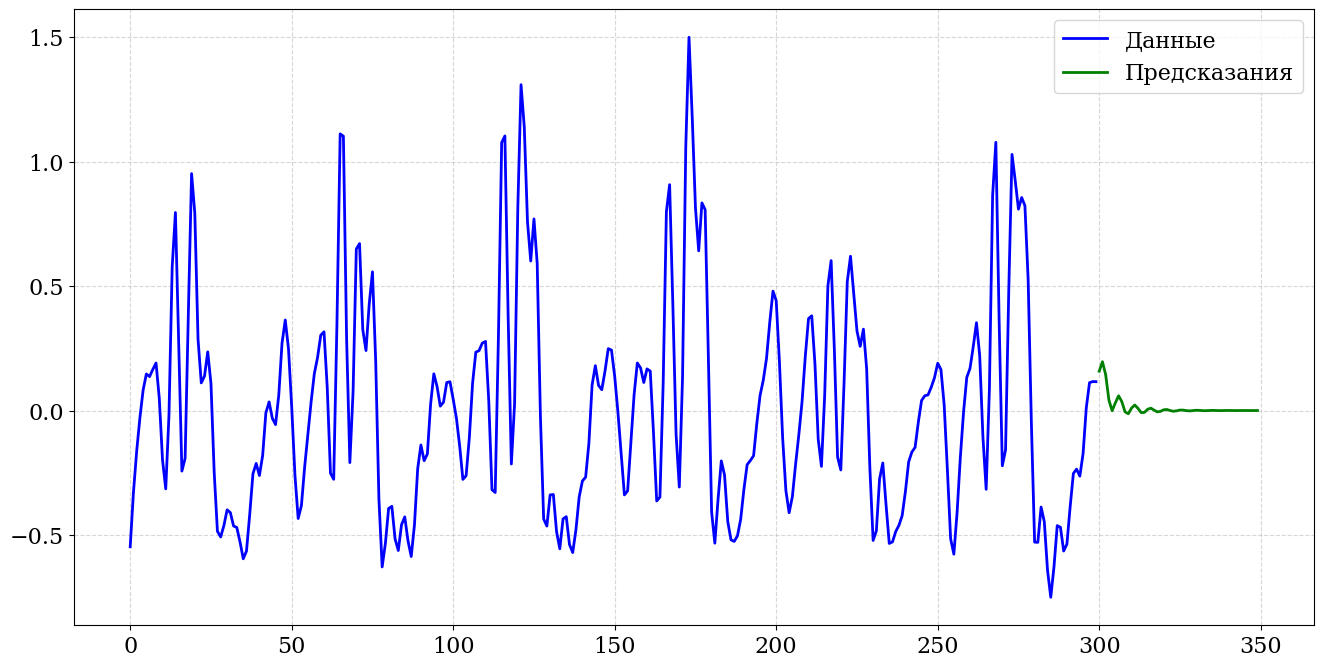

In [67]:
# Load/split your data
y = ts_ssa_acc.reconstruct(slice(0,5))
train, test = train_test_split(y, train_size=300)

model = pm.auto_arima(train, seasonal=True, m=12)
forecasts_ssa = model.predict(test.shape[0])
x = np.arange(y.shape[0])
plt.plot(x[:300], train, c='blue', label='Данные')
plt.plot(x[300:], forecasts_ssa, c='green', label='Предсказания')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

###На начальном

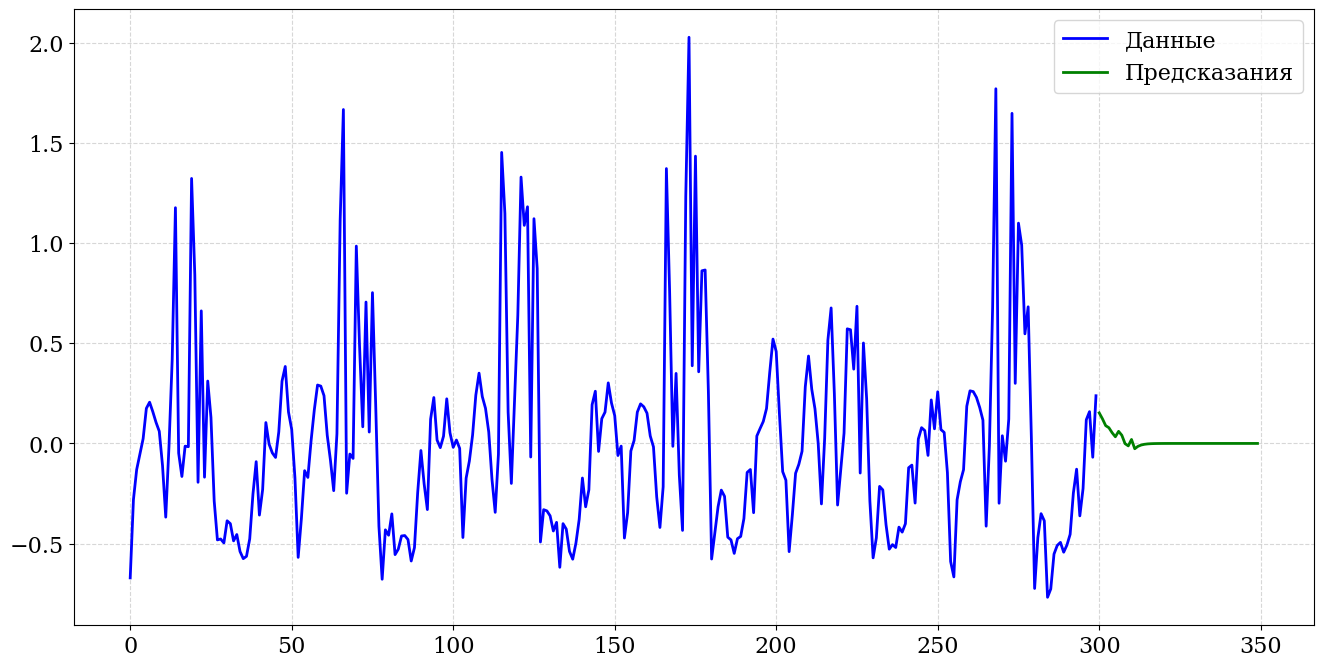

In [68]:
size_dataset = 350
size_test = 50
size_train = size_dataset - size_test

ts = ts = data.acc.values[:size_dataset]
ts = ts-ts.mean()
train, test = train_test_split(ts, train_size=size_train)

model = pm.auto_arima(train, seasonal=True, m=12)
forecasts_ts = model.predict(test.shape[0])
x = np.arange(ts.shape[0])
plt.plot(x[:size_train], train, c='blue', label='Данные')
plt.plot(x[size_train:], forecasts_ts, c='green', label='Предсказания')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

##Сравнение и анализ

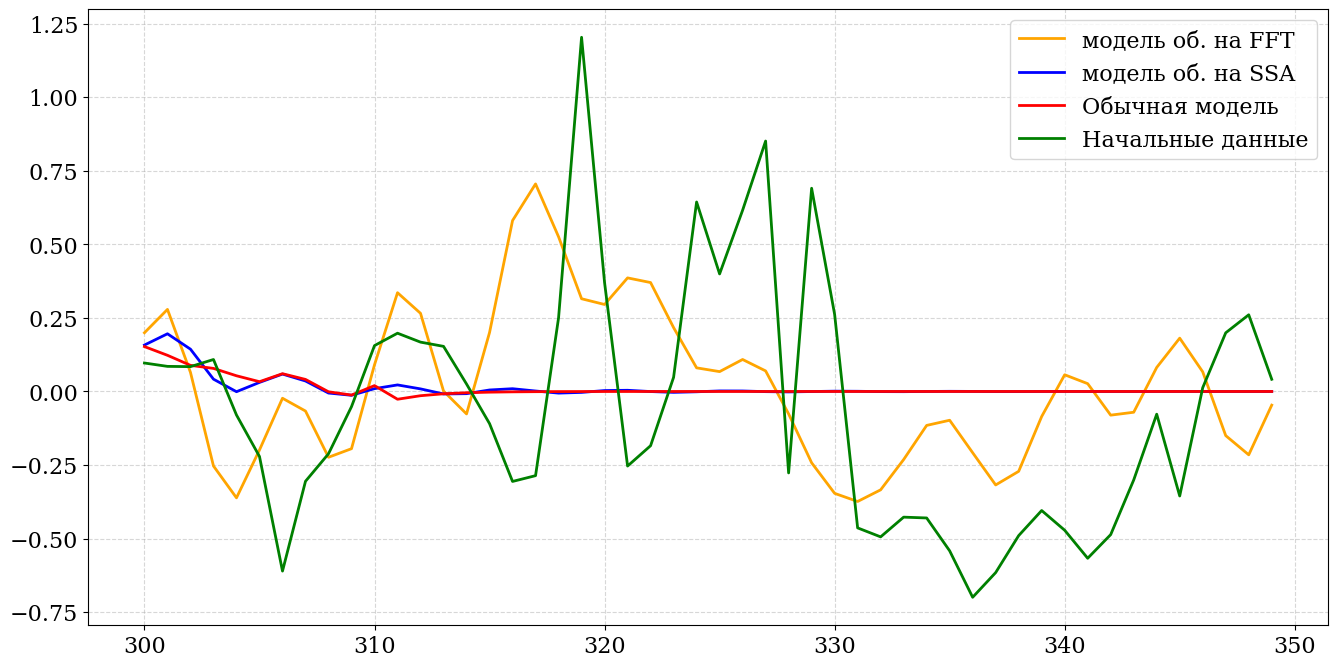

In [70]:
x = np.arange(y.shape[0])
plt.plot(x[300:], forecasts_fft, c='orange', label = 'модель об. на FFT')
plt.plot(x[300:], forecasts_ssa, c='blue', label = 'модель об. на SSA')
plt.plot(x[300:], forecasts_ts, c='red', label = 'Обычная модель')
plt.plot(x[300:], ts[300:], c='green', label = 'Начальные данные')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

<font color="green"><b>
Explanation:
</b></font>

---

Как мы видим из графиков, модели тяжело устанавливают зависимости, единсвенная модель котороя неплохо справилась с этим, это модель обученная на данных обработанных с помощью fft.

Это может быть связано с несколькими причинами, одна из которых недостаточное кол-во данных, но я проверял данные модели и с полным датасетом, ситуация была не намного лучше.

Я думаю это вызвано двумя причинами:

**Несоответствие структуры данных**: ARIMA-модель предполагает линейность и стационарность данных. Однако данные акселерометра могут иметь нелинейную или нестационарную структуру, что делает ARIMA-модель неэффективной для предсказания таких данных.

**Неучтенные факторы**: ARIMA-модель предполагает, что временной ряд является стационарным и не учитывает другие факторы, которые могут влиять на данные акселерометра, такие как внешние события, тряска или изменение окружающей среды. Если эти факторы не учтены в модели, ее предсказания могут быть неточными.